---
title: "Modeling DAU with Markov chain"
date: "2024-12-02"
categories: [product analytics, predictive analytics]
draft: false
jupyter: python3
code-fold: true
code-summary: Toggle the code
number-sections: true
---

## Introduction 

Doubtlessly, DAU, WAU, and MAU are critical business metrics. An article ["How Duolingo reignited user growth"](https://www.lennysnewsletter.com/p/how-duolingo-reignited-user-growth) by [Jorge Mazal](https://www.linkedin.com/in/jorgemazal/), former CPO of Duolingo, is #1 in the Growth section of Lenny's Newsletter blog. In this article, Jorge paid special attention to the methodology Duolingo used to model the DAU metric (see another article ["Meaningful metrics: how data sharpened the focus of product teams"](https://blog.duolingo.com/growth-model-duolingo/) by [Erin Gustafson](https://blog.duolingo.com/author/erin/)). This methodology has multiple strengths, but I'd like to focus on how one can use this approach for DAU forecasting.

The new year is coming soon, so many companies are planning their budgets for the next year these days. Cost estimations often require DAU forecasts. In this article, I'll show how you can get this prediction using Duolingo's growth model. I'll explain why this approach is better compared to standard time-series forecasting methods and how you can adjust the prediction according to your teams' plans (e.g., marketing, activation, product teams).

The article text goes along with the code, and a simulated dataset is attached so the research is fully reproducible. The Jupyter notebook version is available [here](https://github.com/wowone/wowone.github.io/blob/master/posts/2024-12-02_dau_prediction/dau_prediction.ipynb). In the end, I'll share a DAU "calculator" designed in Google Spreadsheet format.

I'll be narrating on behalf of the collective "we". I'm used to it because I usually write articles with co-authors.

## Methodology

A quick recap on how the [Duolingo's growth model](https://blog.duolingo.com/growth-model-duolingo/) works. At day $d$ ($d=1,2,\ldots,$) of a user's lifetime, the user can be in one of the following 7 (mutually-exclusive) states: `new`, `current`, `reactivated`, `resurrected`, `at_risk_wau`, `at_risk_mau`, `dormant`. The states are defined according to indicators of whether a user was active today, in the last 7 days, or in the last 30 days. The definition summary is given in the table below:

<table class="caption-top table">
<thead><tr class="header"><th>state</th><th width=120>d = 1</th><th width=120>active<br/>today</th><th width=120>active in<br/>[d-6, d-1]</th><th width=120>active in<br/>[d-29, d-7]</th><th width=150>active<br/>before d-30</th></tr></thead>
<tr><td>new</td><td>✅</td><td>?</td><td>NA</td><td>NA</td><td>NA</td></tr>
<tr><td>current</td><td>❌</td><td>✅</td><td>✅</td><td>❓</td><td>❓</td></tr>
<tr><td>reactivated</td><td>❌</td><td>✅</td><td>❌</td><td>✅</td><td>?</td></tr>
<tr><td>resurrected</td><td>❌</td><td>✅</td><td>❌</td><td>❌</td><td>✅</td></tr>
<tr><td>at_risk_wau</td><td>❌</td><td>❌</td><td>✅</td><td>?</td><td>?</td></tr>
<tr><td>at_risk_mau</td><td>❌</td><td>❌</td><td>❌</td><td>✅</td><td>?</td></tr>
<tr><td>dormant</td><td>❌</td><td>❌</td><td>❌</td><td>❌</td><td>✅</td></tr>
</table>

Having these states defined (as a set $S$), we can consider user behavior as a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain). Here's an example of a user's trajectory: `new`→`current`→`current`→`at_risk_wau`→...→`at_risk_mau`→...→`dormant`. Let $M$ be a transition matrix associated with this Markov process: $m_{i, j} = P(s_j | s_i)$ are the probabilities that a user moves to state $s_j$ right after being at state $s_i$, where $s_i, s_j \in S$. Such a matrix is inferred from the historical data.

If we assume that user behavior is stationary (independent of time), the matrix $M$ fully describes the states of all users in the future. Suppose that the vector $u_0$ of length 7 contains the counts of users in certain states on a given day, denoted as day 0. According to the Markov model, on the next day 1, we expect to have the following number of users states $u_1$:

$$
\underbrace{
\begin{pmatrix}  \#New_1 \\ \#Current_1 \\ \#Reactivated_1 \\ \#Resurrected_1 \\ \#AtRiskWau_1 \\ \#AtRiskMau_1 \\ \#Dormant_1 \end{pmatrix}
}_{u_1} = M^T \cdot 
\underbrace{
\begin{pmatrix}  \#New_0 \\ \#Current_0 \\ \#Reactivated_0 \\ \#Resurrected_0 \\ \#AtRiskWau_0 \\ \#AtRiskMau_0 \\ \#Dormant_0 \end{pmatrix}
}_{u_0}
$$

Applying this formula recursively, we derive the number of users in certain states on any arbitrary day $t > 0$ in the future. Besides the initial distribution $u_0$, we need to provide the number of new users that will appear in the product each day in the future. We'll address this problem as a general time-series forecasting.

Now, having $u_t$ calculated, we can determine DAU values on day $t$:
$$\begin{equation} DAU_t = \#New_t + \#Current_t + \#Reactivated_t + \#Resurrected_t \end{equation}.$$

Additionally, we can easily calculate WAU and MAU metrics:
$$WAU_t = DAU_t + \#AtRiskWau_t,$$
$$MAU_t = DAU_t + \#AtRiskWau_t + \#AtRiskMau_t.$$

Finally, here's the algorithm outline:

1. For each prediction day $t=1, \ldots, T$, calculate the expected number of new users $\#New_1, \ldots, \#New_T$.
2. For each lifetime day of each user, assign one of the 7 states.
3. Calculate the transition matrix $M$ from the historical data.
4. Calculate initial state counts $u_0$ corresponding to day $t=0$.
5. Recursively calculate $u_{t+1} = M^T u_t$.
6. Calculate DAU, WAU, and MAU for each prediction day $t=1, \ldots, T$.

## Implementation

This section is devoted to technical aspects of the implementation. If you're interested in studying the model properties rather than code, you may skip this section and go to the @sec-model-evaluation.

### Dataset

We use a simulated dataset based on historical data of a SaaS app. The data is stored in the [dau_data.csv.gz](https://drive.google.com/file/d/16kd8rJBvcgmw95jY42MedRfIxcO4LpPd/view?usp=sharing) file and contains three columns: `user_id`, `date`, and `registration_date`. Each record indicates a day when a user was active. The dataset includes activity indicators for 51480 users from `2020-11-01` to `2023-10-31`. Additionally, data from October 2020 is included to calculate user states properly, as the `at_risk_mau` and `dormant` states require data from one month prior.

In [1]:
#| code-fold: false

import pandas as pd

df = pd.read_csv('dau_data.csv.gz', compression='gzip')
df['date'] = pd.to_datetime(df['date'])
df['registration_date'] = pd.to_datetime(df['registration_date'])

print(f'Shape: {df.shape}')
print(f'Total users: {df['user_id'].nunique()}')
print(f'Data range: [{df['date'].min()}, {df['date'].max()}]')
df.head()

Shape: (667236, 3)
Total users: 51480
Data range: [2020-10-01 00:00:00, 2023-10-31 00:00:00]


,user_id,date,registration_date
0,d8c465ab-e9fd-5edd-9e4e-c77094700cb5,2020-10-01,2020-08-25
1,269b7f13-a509-5174-85cb-95a8f7b932e8,2020-10-01,2020-08-25
2,bfeac474-5b66-566f-8654-262bb79c873e,2020-10-01,2020-05-31
3,d32fcac5-122c-5463-8aea-01b39b9ad0bb,2020-10-01,2020-09-30
4,c1ece677-e643-5bb3-8701-f1c59a0bf4cd,2020-10-01,2020-09-05


This is how the DAU time-series looks like.

<Axes: title={'center': 'DAU, historical'}, xlabel='date'>

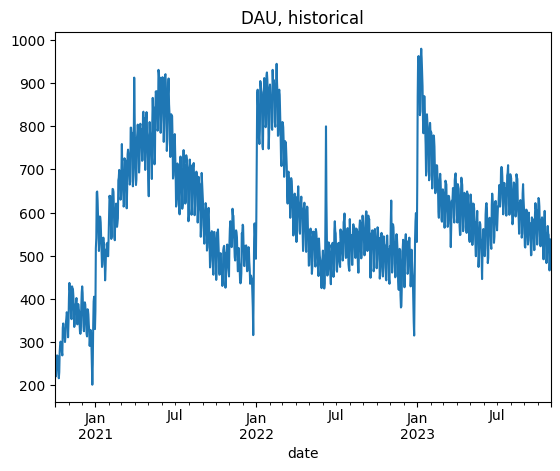

In [2]:
#| code-fold: false

df.groupby('date').size()\
    .plot(title='DAU, historical')

Suppose that today is 2023-10-31 and we want to predict the DAU metric for the next 2024 year. We define a couple of global constants `PREDICTION_START` and `PREDICTION_END` which encompass the prediction period.

In [3]:
#| code-fold: false

PREDICTION_START = '2023-11-01'
PREDICTION_END = '2024-12-31'

### Predicting new users amount

Let's start from the new users prediction. We use the [prophet](http://facebook.github.io/prophet/) library as one of the easiest ways to forecast time-series data. The `new_users` Series contains such data. We extract it from the original `df` dataset selecting the rows where the `registration date` is equal to the `date`.

In [34]:
new_users = df[df['date'] == df['registration_date']]\
    .groupby('date').size()

In [5]:
#| code-fold: false

new_users.head()

date
2020-10-01    4
2020-10-02    4
2020-10-03    3
2020-10-04    4
2020-10-05    8
dtype: int64

`prophet` requires a time-series as a DataFrame containing two columns `ds` and `y`, so we reformat the `new_users` Series to the `new_users_prophet` DataFrame. Another thing we need to prepare is to create the `future` variable containing certain days for prediction: from `prediction_start` to `prediction_end`. This logic is implemented in the `predict_new_users` function. The plot below illustrates predictions for both past and future periods. 

In [6]:
import logging
import matplotlib.pyplot as plt
from prophet import Prophet

# suppress prophet logs
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').disabled=True

def predict_new_users(prediction_start, prediction_end, new_users_train, show_plot=True):
    """
    Forecasts a time-seires for new users

    Parameters
    ----------
    prediction_start : str
        Date in YYYY-MM-DD format.
    prediction_end : str
        Date in YYYY-MM-DD format.
    new_users_train : pandas.Series
        Historical data for the time-series preceding the prediction period.
    show_plot : boolean, default=True
        If True, a chart with the train and predicted time-series values is displayed.
    Returns
    -------
    pandas.Series
        Series containing the predicted values.
    """
    m = Prophet()

    new_users_train = new_users_train.loc[new_users_train.index < prediction_start]
    new_users_prophet = pd.DataFrame({'ds': new_users_train.index, 'y': new_users_train.values})

    m.fit(new_users_prophet)

    periods = len(pd.date_range(prediction_start, prediction_end))
    future = m.make_future_dataframe(periods=periods)
    new_users_pred = m.predict(future)
    if show_plot:
        m.plot(new_users_pred)
        plt.title('New users prediction');

    new_users_pred = new_users_pred\
        .assign(yhat=lambda _df: _df['yhat'].astype(int))\
        .rename(columns={'ds': 'date', 'yhat': 'count'})\
        .set_index('date')\
        .clip(lower=0)\
        ['count']

    return new_users_pred

/Users/v.kukushkin/Documents/private/wowone.github.io/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


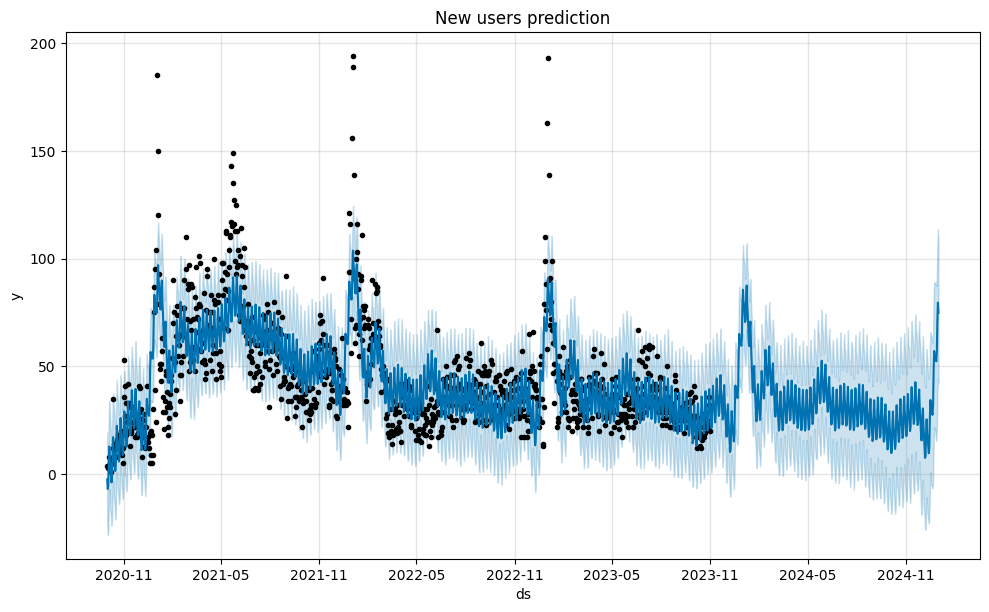

In [7]:
#| code-fold: false

new_users_pred = predict_new_users(PREDICTION_START, PREDICTION_END, new_users)

The `new_users_pred` Series stores the predicted users amount.

In [8]:
#| code-fold: false

new_users_pred.tail(5)

date
2024-12-27    52
2024-12-28    56
2024-12-29    71
2024-12-30    79
2024-12-31    74
Name: count, dtype: int64

### Getting the states

In practice, the most calculations are reasonable to execute as SQL queries to a database where the data is stored. Hereafter, we will simulate such querying using the [duckdb](https://duckdb.org) library.

We want to assign one of the 7 states to each day of a user's lifetime within the app. According to the definition, for each day, we need to consider at least the past 30 days. This is where SQL window functions come in. However, since the `df` data contains only records of *active days*, we need to explicitly extend them and include the days when a user was not active. In other words, instead of this list of records:

```
user_id    date          registration_date
1234567    2023-01-01    2023-01-01
1234567    2023-01-03    2023-01-01
```

we'd like to get a list like this:

```
user_id    date          is_active    registration_date
1234567    2023-01-01    TRUE         2023-01-01
1234567    2023-01-02    FALSE        2023-01-01
1234567    2023-01-03    TRUE         2023-01-01
1234567    2023-01-04    FALSE        2023-01-01
1234567    2023-01-05    FALSE        2023-01-01
...        ...           ...          ...
1234567    2023-10-31    FALSE        2023-01-01
```

For readability purposes we split the following SQL query into multiple subqueries.

- `full_range`: Create a full sequence of dates for each user.
- `dau_full`: Get the full list of both active and inactive records.
- `states`: Assign one of the 7 states for each day of a user's lifetime.

In [9]:
import duckdb

DATASET_START = '2020-11-01'
DATASET_END = '2023-10-31'
OBSERVATION_START = '2020-10-01'

query = f"""
WITH
full_range AS (
    SELECT
        user_id, UNNEST(generate_series(greatest(registration_date, '{OBSERVATION_START}'), date '{DATASET_END}', INTERVAL 1 DAY))::date AS date
    FROM (
        SELECT DISTINCT user_id, registration_date FROM df
    )
),
dau_full AS (
    SELECT
        fr.user_id,
        fr.date,
        df.date IS NOT NULL AS is_active,
        registration_date
    FROM full_range AS fr
    LEFT JOIN df USING(user_id, date)
),
states AS (
    SELECT
        user_id,
        date,
        is_active,
        first_value(registration_date IGNORE NULLS) OVER (PARTITION BY user_id ORDER BY date) AS registration_date,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 6 PRECEDING and 1 PRECEDING) AS active_days_back_6d,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 29 PRECEDING and 1 PRECEDING) AS active_days_back_29d,
        CASE
            WHEN date = registration_date THEN 'new'
            WHEN is_active = TRUE AND active_days_back_6d BETWEEN 1 and 6 THEN 'current'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) > 0 THEN 'reactivated'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) = 0 THEN 'resurrected'
            WHEN is_active = FALSE AND active_days_back_6d > 0 THEN 'at_risk_wau'
            WHEN is_active = FALSE AND active_days_back_6d = 0 AND ifnull(active_days_back_29d, 0) > 0 THEN 'at_risk_mau'
            ELSE 'dormant'
        END AS state
    FROM dau_full
)
SELECT user_id, date, state FROM states
WHERE date BETWEEN '{DATASET_START}' AND '{DATASET_END}'
ORDER BY user_id, date
"""
states = duckdb.sql(query).df()

The query results are kept in the `states` DataFrame:

In [10]:
#| code-fold: false

states.head()

,user_id,date,state
0,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-23,new
1,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-24,current
2,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-25,current
3,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-26,current
4,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-27,current


### Calculating the transition matrix 

Having obtained these states, we can calculate state transition frequencies. In the @sec-transitions-period-impact we'll study how the prediction depends on a period in which transitions are considered, so it's reasonable to pre-aggregate this data on daily basis. The resulting `transitions` DataFrame contains `date`, `state_from`, `state_to`, and `cnt` columns.

In [11]:
query = f"""
SELECT
    date,
    state_from,
    state_to,
    COUNT(*) AS cnt,
FROM (
    SELECT
        date,
        state AS state_to,
        lag(state) OVER (PARTITION BY user_id ORDER BY date) AS state_from
    FROM states
)
WHERE state_from IS NOT NULL
GROUP BY date, state_from, state_to
ORDER BY date, state_from, state_to;
"""
transitions = duckdb.sql(query).df()

In [12]:
#| code-fold: false

transitions.head()

,date,state_from,state_to,cnt
0,2020-11-02,at_risk_mau,at_risk_mau,273
1,2020-11-02,at_risk_mau,dormant,4
2,2020-11-02,at_risk_mau,reactivated,14
3,2020-11-02,at_risk_wau,at_risk_mau,18
4,2020-11-02,at_risk_wau,at_risk_wau,138


Now, we can calculate the transition matrix $M$. We implement the `get_transition_matrix` function, which accepts the `transitions` DataFrame and a pair of dates that encompass the transitions period to be considered.

In [13]:
states_order = ['new', 'current', 'reactivated', 'resurrected', 'at_risk_wau', 'at_risk_mau', 'dormant']

def get_transition_matrix(transitions, date1, date2):
    if pd.to_datetime(date1) > pd.to_datetime(DATASET_END):
        date1 = pd.to_datetime(DATASET_END) - pd.Timedelta(days=30)

    probs = transitions\
        .loc[lambda _df: _df['date'].between(date1, date2)]\
        .groupby(['state_from', 'state_to'], as_index=False)\
        ['cnt'].sum()\
        .assign(
            supp=lambda _df: _df.groupby('state_from')['cnt'].transform('sum'),
            prob=lambda _df: _df['cnt'] / _df['supp']
        )

    M = probs.pivot(index='state_from', columns='state_to', values='prob')\
        .reindex(states_order, axis=0)\
        .reindex(states_order, axis=1)\
        .fillna(0)\
        .astype(float)

    return M


As a baseline, let's calculate the transition matrix for the whole year from `2022-11-01` to `2023-10-31`.

In [14]:
#| code-fold: false

M = get_transition_matrix(transitions, '2022-11-01', '2023-10-31')
M

state_to,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant
state_from,,,,,,,
new,0.0,0.515934,0.000000,0.000000,0.484066,0.000000,0.000000
current,0.0,0.851325,0.000000,0.000000,0.148675,0.000000,0.000000
reactivated,0.0,0.365867,0.000000,0.000000,0.634133,0.000000,0.000000
resurrected,0.0,0.316474,0.000000,0.000000,0.683526,0.000000,0.000000
at_risk_wau,0.0,0.098246,0.004472,0.000000,0.766263,0.131020,0.000000
at_risk_mau,0.0,0.000000,0.009598,0.000173,0.000000,0.950109,0.040120
dormant,0.0,0.000000,0.000000,0.000387,0.000000,0.000000,0.999613


The sum of each row of any transition matrix equals 1 since it represents the probabilities of moving from one state to any other state. 

### Getting the initial state counts

An initial state is retrieved from the `states` DataFrame by the `get_state0` function and the corresponding SQL query. The only argument of the function is the date for which we want to get the initial state. We assign the result to the `state0` variable.

In [15]:
def get_state0(date):
    query = f"""
    SELECT state, count(*) AS cnt
    FROM states
    WHERE date = '{date}'
    GROUP BY state
    """

    state0 = duckdb.sql(query).df()
    state0 = state0.set_index('state').reindex(states_order)['cnt']
    
    return state0


In [16]:
#| code-fold: false

state0 = get_state0(DATASET_END)
state0

state
new               20
current          475
reactivated       15
resurrected       19
at_risk_wau      404
at_risk_mau     1024
dormant        49523
Name: cnt, dtype: int64

### Predicting DAU {#sec-predicting-dau}

The `predict_dau` function below accepts all the previous variables required for the DAU prediction and makes this prediction for a date range defined by the `start_date` and `end_date` arguments.

In [17]:
def predict_dau(M, state0, start_date, end_date, new_users):
    """
    Predicts DAU over a given date range.

    Parameters
    ----------
    M : pandas.DataFrame
        Transition matrix representing user state changes.
    state0 : pandas.Series
        counts of initial state of users.
    start_date : str
        Start date of the prediction period in 'YYYY-MM-DD' format.
    end_date : str
        End date of the prediction period in 'YYYY-MM-DD' format.
    new_users : int or pandas.Series
        The expected amount of new users for each day between `start_date` and `end_date`.
        If a Series, it should have dates as the index.
        If an int, the same number is used for each day.
        
    Returns
    -------
    pandas.DataFrame
        DataFrame containing the predicted DAU, WAU, and MAU for each day in the date range,
        with columns for different user states and tot.
    """
    
    dates = pd.date_range(start_date, end_date)
    dates.name = 'date'
    dau_pred = []
    new_dau = state0.copy()
    for date in dates:
        new_dau = (M.transpose() @ new_dau).astype(int)
        if isinstance(new_users, int):
            new_users_today = new_users
        else:
            new_users_today = new_users.astype(int).loc[date] 
        new_dau.loc['new'] = new_users_today
        dau_pred.append(new_dau.tolist())

    dau_pred = pd.DataFrame(dau_pred, index=dates, columns=states_order)
    dau_pred['dau'] = dau_pred['new'] + dau_pred['current'] + dau_pred['reactivated'] + dau_pred['resurrected']
    dau_pred['wau'] = dau_pred['dau'] + dau_pred['at_risk_wau']
    dau_pred['mau'] = dau_pred['dau'] + dau_pred['at_risk_wau'] + dau_pred['at_risk_mau']
    
    return dau_pred

In [18]:
#| code-fold: false

dau_pred = predict_dau(M, state0, PREDICTION_START, PREDICTION_END, new_users_pred)
dau_pred

,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant,dau,wau,mau
date,,,,,,,,,,
2023-11-01,29,465,11,19,412,1025,49544,524,936,1961
2023-11-02,25,461,11,19,418,1027,49565,516,934,1961
2023-11-03,21,456,11,19,420,1030,49587,507,927,1957
2023-11-04,22,450,11,19,419,1033,49609,502,921,1954
2023-11-05,34,445,11,19,418,1036,49631,509,927,1963
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,52,505,12,24,487,1129,61599,593,1080,2209
2024-12-28,56,516,13,24,497,1136,61620,609,1106,2242
2024-12-29,71,529,13,24,509,1144,61641,637,1146,2290


This is how the DAU prediction `dau_pred` looks like for the `PREDICTION_START` - `PREDICTION_END` period. Besides the expected `dau`, `wau`, and `mau` columns, the output contains the number of users in each state for each prediction date.

Finally, we calculate the ground-truth values of DAU, WAU, and MAU (along with the user state counts), keep them in the `dau_true` DataFrame, and plot the predicted and true values altogether.

In [19]:
query = f"""
SELECT date, state, COUNT(*) AS cnt
FROM states
GROUP BY date, state
ORDER BY date, state;
"""

dau_true = duckdb.sql(query).df()
dau_true['date'] = pd.to_datetime(dau_true['date'])
dau_true = dau_true.pivot(index='date', columns='state', values='cnt')
dau_true['dau'] = dau_true['new'] + dau_true['current'] + dau_true['reactivated'] + dau_true['resurrected']
dau_true['wau'] = dau_true['dau'] + dau_true['at_risk_wau']
dau_true['mau'] = dau_true['dau'] + dau_true['at_risk_wau'] + dau_true['at_risk_mau']

In [20]:
#| code-fold: false

dau_true.head()

state,at_risk_mau,at_risk_wau,current,dormant,new,reactivated,resurrected,dau,wau,mau
date,,,,,,,,,,
2020-11-01,291.0,207.0,293.0,840.0,36.0,14.0,3.0,346.0,553.0,844.0
2020-11-02,291.0,208.0,327.0,836.0,53.0,14.0,8.0,402.0,610.0,901.0
2020-11-03,296.0,205.0,383.0,840.0,41.0,10.0,3.0,437.0,642.0,938.0
2020-11-04,296.0,246.0,375.0,842.0,27.0,13.0,6.0,421.0,667.0,963.0
2020-11-05,300.0,275.0,373.0,845.0,33.0,8.0,4.0,418.0,693.0,993.0


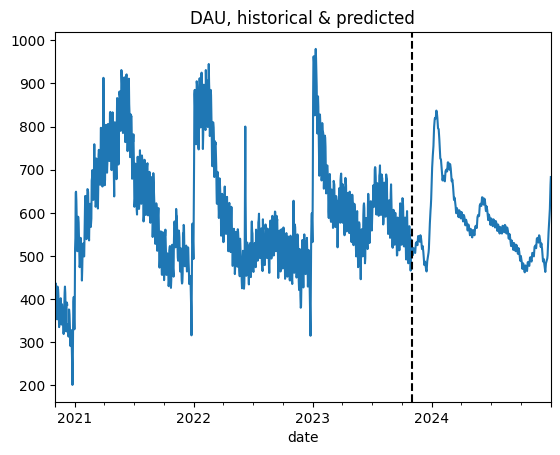

In [21]:
pd.concat([dau_true['dau'], dau_pred['dau']])\
    .plot(title='DAU, historical & predicted');
plt.axvline(PREDICTION_START, color='k', linestyle='--');

We've obtained the prediction but so far it's not clear whether it's fair or not. In the next section, we'll evaluate the model.

## Model evaluation {#sec-model-evaluation}

### Baseline model {#sec-baseline-model}

First of all, let's check whether we really need to build a complex model to predict DAU. Wouldn't it be better to predict DAU as a general time-series using the mentioned `prophet` library? The function `predict_dau_prophet` below implements this. We try to use some tweaks available in the library in order to make the prediction more accurate. In particular:

- we use logistic model instead of linear to avoid negative values;
- we add explicitly monthly and yearly seasonality;
- we remove the outliers;
- we explicitly define a peak period in January and February as "holidays".

In [22]:
def predict_dau_prophet(prediction_start, prediction_end, dau_true, show_plot=True):
    # assigning peak days for the new year
    holidays = pd.DataFrame({
        'holiday': 'january_spike',
        'ds': pd.date_range('2022-01-01', '2022-01-31', freq='D').tolist() + \
              pd.date_range('2023-01-01', '2023-01-31', freq='D').tolist(),
        'lower_window': 0,
        'upper_window': 40
    })

    m = Prophet(growth='logistic', holidays=holidays)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=3)
    m.add_seasonality(name='yearly', period=365, fourier_order=3)

    train = dau_true.loc[(dau_true.index < prediction_start) & (dau_true.index >= '2021-08-01')]
    train_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    # removining outliers
    train_prophet.loc[train_prophet['ds'].between('2022-06-07', '2022-06-09'), 'y'] = None
    train_prophet['new_year_peak'] = (train_prophet['ds'] >= '2022-01-01') &\
                                     (train_prophet['ds'] <= '2022-02-14')
    m.add_regressor('new_year_peak')
    # setting logistic upper and lower bounds
    train_prophet['cap'] = dau_true.max() * 1.1
    train_prophet['floor'] = 0

    m.fit(train_prophet)

    periods = len(pd.date_range(prediction_start, prediction_end))
    future = m.make_future_dataframe(periods=periods)
    future['new_year_peak'] = (future['ds'] >= '2022-01-01') & (future['ds'] <= '2022-02-14')
    future['cap'] = dau_true.max() * 1.1
    future['floor'] = 0
    pred = m.predict(future)

    if show_plot:
        m.plot(pred);

    # converting the predictions to an appropriate format
    pred = pred\
        .assign(yhat=lambda _df: _df['yhat'].astype(int))\
        .rename(columns={'ds': 'date', 'yhat': 'count'})\
        .set_index('date')\
        .clip(lower=0)\
        ['count']\
        .loc[lambda s: (s.index >= prediction_start) & (s.index <= prediction_end)]

    return pred

The fact that the code turns out to be quite sophisticated indicates that one can't simply apply `prophet` to the DAU time-series.

Hereafter we test a prediction for multiple predicting horizonts: 3, 6, and 12 months. As a result, we get 3 test sets:

- 3-months horizont: `2023-08-01` -  `2023-10-31`,
- 6-months horizont: `2023-05-01` -  `2023-10-31`,
- 1-year horizont: `2022-11-01` -  `2023-10-31`.

For each test set we calculate the [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) loss function.

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

mapes = []
prediction_end = '2023-10-31'
prediction_horizont = [3, 6, 12]

for offset in prediction_horizont:
    prediction_start = pd.to_datetime(prediction_end) - pd.DateOffset(months=offset - 1)
    prediction_start = prediction_start.replace(day=1)
    prediction_end = '2023-10-31'
    pred = predict_dau_prophet(prediction_start, prediction_end, dau_true['dau'], show_plot=False)
    mape = mean_absolute_percentage_error(dau_true['dau'].reindex(pred.index), pred)
    mapes.append(mape)

mapes = pd.DataFrame({'horizont': prediction_horizont, 'MAPE': mapes})
mapes

,horizont,MAPE
0,3,0.350167
1,6,0.185246
2,12,0.215338


The MAPE error turns out to be high: 18% - 35%. The fact that the shortest horizont has the highest error means that the model is tuned for the long-term predictions. This is another inconvenience of such an approach: we have to tune the model for each prediction horizont. Anyway, this is our baseline. In the next section we'll compare it with more advanced models.

### General evaluation {#sec-general-evaluation}

In this section we evaluate the model implemented in the @sec-predicting-dau. So far we set the transition period as 1 year before the prediction start. We'll study how the prediction depends on the transition period in the @sec-transitions-period-impact. As for the new users, we run the model using two options: the real values and the predicted ones. Similarly, we fix the same 3 prediction horizonts and test the model on them.

The `make_predicion` helper function below implements the described options. It accepts `prediction_start`, `prediction_end` arguments defining the prediction period for a given horizont, `new_users_mode` which can be either `true` or `predict`, and `transition_period`. The options of the latter argument will be explained further.

In [24]:
import re


def make_prediction(prediction_start, prediction_end, new_users_mode='predict', transition_period='last_30d'):
    prediction_start_minus_1d = pd.to_datetime(prediction_start) - pd.Timedelta('1d')
    state0 = get_state0(prediction_start_minus_1d)
    
    if new_users_mode == 'predict':
        new_users_pred = predict_new_users(prediction_start, prediction_end, new_users, show_plot=False)
    elif new_users_mode == 'true':
        new_users_pred = new_users.copy()

    if transition_period.startswith('last_'):
        shift = int(re.search(r'last_(\d+)d', transition_period).group(1))
        transitions_start = pd.to_datetime(prediction_start) - pd.Timedelta(shift, 'd')
        M = get_transition_matrix(transitions, transitions_start, prediction_start_minus_1d)
        dau_pred = predict_dau(M, state0, prediction_start, prediction_end, new_users_pred)
    else:
        transitions_start = pd.to_datetime(prediction_start) - pd.Timedelta(240, 'd')
        M_base = get_transition_matrix(transitions, transitions_start, prediction_start_minus_1d)
        dau_pred = pd.DataFrame()

        month_starts = pd.date_range(prediction_start, prediction_end, freq='1MS')
        N = len(month_starts)

        for i, prediction_month_start in enumerate(month_starts):
            prediction_month_end = pd.offsets.MonthEnd().rollforward(prediction_month_start)
            transitions_month_start = prediction_month_start - pd.Timedelta('365D')
            transitions_month_end = prediction_month_end - pd.Timedelta('365D')

            M_seasonal = get_transition_matrix(transitions, transitions_month_start, transitions_month_end)
            if transition_period == 'smoothing':
                i = min(i, 12)
                M = M_seasonal * i / (N - 1)  + (1 - i / (N - 1)) * M_base
            elif transition_period.startswith('seasonal_'):
                seasonal_coef = float(re.search(r'seasonal_(0\.\d+)', transition_period).group(1))
                M = seasonal_coef * M_seasonal + (1 - seasonal_coef) * M_base
            
            dau_tmp = predict_dau(M, state0, prediction_month_start, prediction_month_end, new_users_pred)
            dau_pred = pd.concat([dau_pred, dau_tmp])

            state0 = dau_tmp.loc[prediction_month_end][states_order]

    return dau_pred

def prediction_details(dau_true, dau_pred, show_plot=True, ax=None):
    y_true = dau_true.reindex(dau_pred.index)['dau']
    y_pred = dau_pred['dau']
    mape = mean_absolute_percentage_error(y_true, y_pred) 

    if show_plot:
        prediction_start = str(y_true.index.min().date())
        prediction_end = str(y_true.index.max().date())
        if ax is None:
            y_true.plot(label='DAU true')
            y_pred.plot(label='DAU pred')
            plt.title(f'DAU prediction, {prediction_start} - {prediction_end}')
            plt.legend()
        else:
            y_true.plot(label='DAU true', ax=ax)
            y_pred.plot(label='DAU pred', ax=ax)
            ax.set_title(f'DAU prediction, {prediction_start} - {prediction_end}')
            ax.legend()
    return mape


In total, we have 6 prediction scenarios: 2 options for new users and 3 prediction horizonts. The diagram below illustrates the results. The charts on the left relate to the `new_users_mode = 'predict'` option, while the right ones relate to the `new_users_mode = 'true'` option.

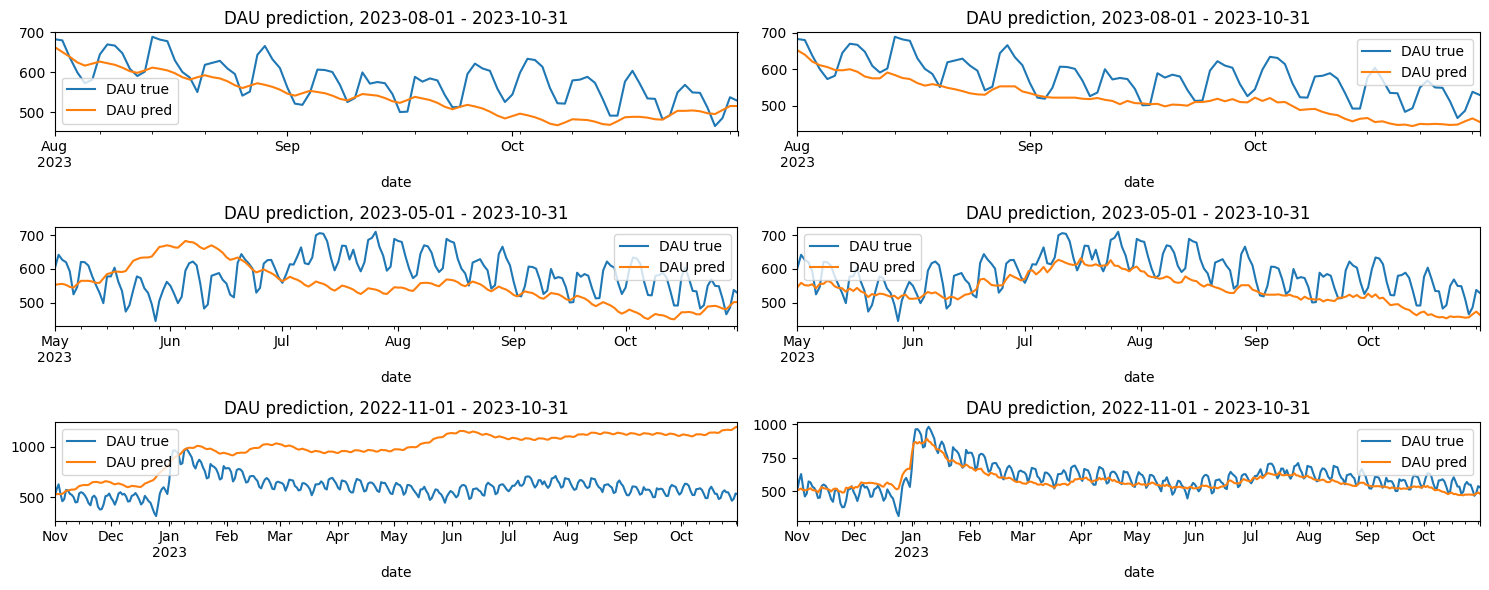

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(15, 6))
mapes = []
prediction_end = '2023-10-31'
prediction_horizont = [3, 6, 12]

for i, offset in enumerate(prediction_horizont):
    prediction_start = pd.to_datetime(prediction_end) - pd.DateOffset(months=offset - 1)
    prediction_start = prediction_start.replace(day=1)
    args = {
        'prediction_start': prediction_start,
        'prediction_end': prediction_end,
        'transition_period': 'last_365d'
    }
    for j, new_users_mode in enumerate(['predict', 'true']):
        args['new_users_mode'] = new_users_mode
        dau_pred = make_prediction(**args)
        mape = prediction_details(dau_true, dau_pred, ax=axs[i, j])
        mapes.append([offset, new_users_mode, mape])

mapes = pd.DataFrame(mapes, columns=['horizont', 'new_users', 'MAPE'])
plt.tight_layout()

And here are the MAPE values summarizing the prediction quality:

In [ ]:
mapes.pivot(index='horizont', columns='new_users_mode', values='MAPE')

new_users,predict,true
horizont,,
3,0.079538,0.103631
6,0.125035,0.084652
12,0.651502,0.086885


We notice multiple things.

- In general, the model demonstrates much better results than the baseline. Indeed, the baseline is based on the historical DAU data only, while the model uses the user states information. 
- However, for the 1-year horizont and `new_users_mode='predict'` the MAPE error is huge: 65%. This is 3 times higher than the corresponding baseline error (21%). On the other hand, `new_users_mode='true'` option gives a much better result: 8%. It means that the new users prediction has a huge impact on the model, especially for long-term predictions. For the shorter periods the difference is less dramatic. The major reason for such a difference is that 1-year period includes Christmas with its extreme values. As a result, i) it's hard to predict such high new user values, ii) the period heavily impacts user behavior, the transition matrix and, consequently, DAU values. Hence, we strongly recommend to implement the new user prediction carefully. The baseline model was specially tuned for this Christmas period, so it's not surprising that it outperforms the Markov model.
- When the new users prediction is accurate, the model captures trends well. It means that using last 365 days for the transition matrix calculation is a reasonable choice.
- Interestingly, the true new users data provides worse results for the 3-months prediction. This is nothing but a coincidence. The wrong new users prediction in October 2023 reversed the predicted DAU trend and made MAPE a bit lower.

Now, let's decompose the prediction error and see which states contribure the most. By error we mean here `dau_pred` - `dau_true` values, by relative error -- (`dau_pred` - `dau_true`) / `dau_true` -- see left and right diagrams below correspondingly. In order to focus on this aspect, we'll narrow the configuration to the 3-months prediction horizont and the `new_users_mode='true'` option. 

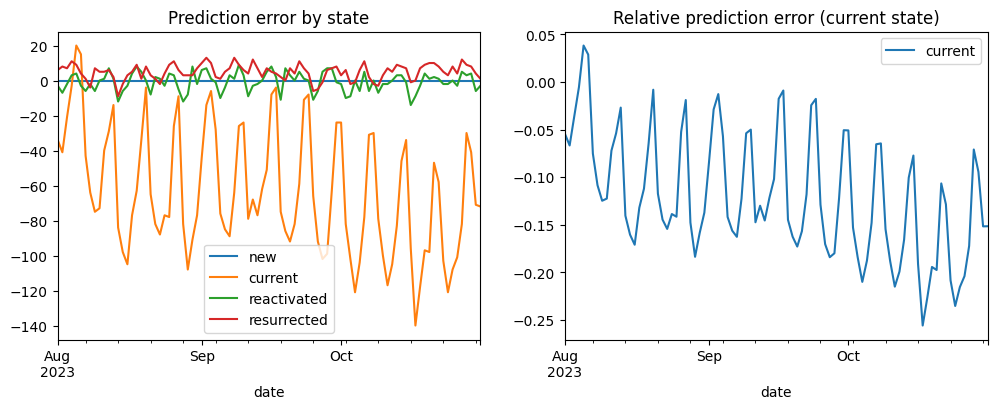

In [27]:
dau_component_cols = ['new', 'current', 'reactivated', 'resurrected']

dau_pred = make_prediction('2023-08-01', '2023-10-31', new_users_mode='true', transition_period='last_365d')
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dau_pred[dau_component_cols]\
    .subtract(dau_true[dau_component_cols])\
    .reindex(dau_pred.index)\
    .plot(title='Prediction error by state', ax=ax1)

dau_pred[['current']]\
    .subtract(dau_true[['current']])\
    .div(dau_true[['current']])\
    .reindex(dau_pred.index)\
    .plot(title='Relative prediction error (current state)', ax=ax2);

From the left chart we notice that the error is basically contributed by the `current` state. It's not surprising since this state contributes to DAU the most. The error for the `reactivated`, and `resurrected` states is quite low. Another interesting thing is that this error is mostly negative for the `current` state and mostly positive for the `resurrected` state. The former might be explained by the fact that the new users who appeared in the prediction period are more engaged that the users from the past. The latter indicates that the `resurrected` users in reality contribute to DAU less than the transition matrix expects, so the `dormant`→`resurrected` conversion rate is overestimated.

As for the relative error, it makes sense to analyze it for the `current` state only. This is because the daily amount of the reactivated and resurrected states are low so the relative error is high and noisy. The relative error for the `current` state varies between -25% and 4% which is quite high. And since we've fixed the new users prediction, this error is explained by the transition matrix inaccuracy only. In particular, the `current`→`current` conversion rate is roughly 0.8 which is high and, as a result, it contributes to the error a lot. So if we want to improve the prediction we need to consider tuning this conversion rate foremost.

### Transitions period impact {#sec-transitions-period-impact}

In the previous section we kept the transitions period fixed: 1 year before a prediction start. Now we're going to study how long this period should be to get more accurate prediction. We consider the same prediction horizonts of 3, 6, and 12 months. In order to mitigate the noise from the new users prediction, we use the real values of the new users amount: `new_users_mode='true'`.

Here comes varying of the `transition_period` argument. Its values are masked with the `last_<N>d` pattern where `N` stands for the number of days in a transitions period. For each prediction horizont we calculate 12 different transition periods of 1, 2, ..., 12 months. Then we calculate the MAPE error for each of the options and plot the results.

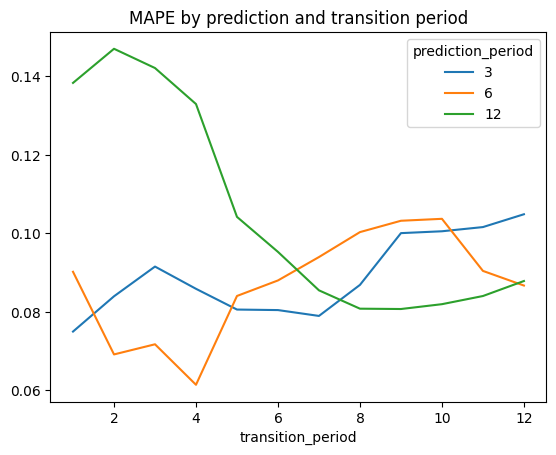

In [28]:
result = []

for prediction_offset in prediction_horizont:
    prediction_start = pd.to_datetime(prediction_end) - pd.DateOffset(months=prediction_offset - 1)
    prediction_start = prediction_start.replace(day=1)

    for transition_offset in range(1, 13):
        dau_pred = make_prediction(
            prediction_start, prediction_end, new_users_mode='true',
            transition_period=f'last_{transition_offset*30}d'
        )
        mape = prediction_details(dau_true, dau_pred, show_plot=False)
        result.append([prediction_offset, transition_offset, mape])
result = pd.DataFrame(result, columns=['prediction_period', 'transition_period', 'mape'])

result.pivot(index='transition_period', columns='prediction_period', values='mape')\
    .plot(title='MAPE by prediction and transition period');

It turns out that the optimal transitions period depends on the prediction horizont. Shorter horizonts require shorter transitions periods: the minimal MAPE error is achieved at 1, 4, and 8 transition periods for the 3, 6, and 12 months correspondingly. Apparently, this is because the longer horizonts contain some seasonal effects that could be captured only by the longer transitions periods. Also, it seems that for the longer prediction horizonts the MAPE curve is U-shaped meaning that too long and too short transitions periods are both not good for the prediction. We'll develop this idea in the next section.

### Obsolence and seasonality

Nevertheless, fixing a single transition matrix for predicting the whole year ahead doesn't seem to be a good idea: such a model would be too rigid. Usually, user behavior varies depending on a season. For example, users who appear after Christmas might have some shifts in behavior. Another typical situation is when users change their behavior in summer. In this section, we'll try to take into account these seasonal effects.

So we want to predict DAU for 1 year ahead starting from November 2022. Instead of using a single transition matrix $M_{base}$ which is calculated for the last 8 months before the prediction start, according to the previous subsection results (and labeled as the `last_240d` option below), we'll consider a mixture of this matrix and a seasonal one $M_{seasonal}$. The latter is calculated on monthly basis lagging 1 year behind. For example, to predict DAU for November 2022 we define $M_{seasonal}$ as the transition matrix for November 2021. Then we shift the prediction horizont to December 2022 and calculate $M_{seasonal}$ for December 2021, etc.

In order to mix $M_{base}$ and $M_{seasonal}$ we define the following two options.

- `seasonal_0.3`: $M = 0.3 \cdot M_{seasonal} + 0.7 \cdot M_{base}$. 0.3 is a weight that was chosen as a local minimum after some experiments.
- `smoothing`: $M = \frac{i}{N - 1} M_{seasonal} + (1 - \frac{i}{N - 1}) M_{base}$ where $N$ is the number of months within the predicting period, $i = 0, \ldots, N - 1$ -- the month index. The idea of this configuration is to gradually switch from the most recent transition matrix $M_{base}$ to seasonal ones as the prediction month moves forward from the prediction start.

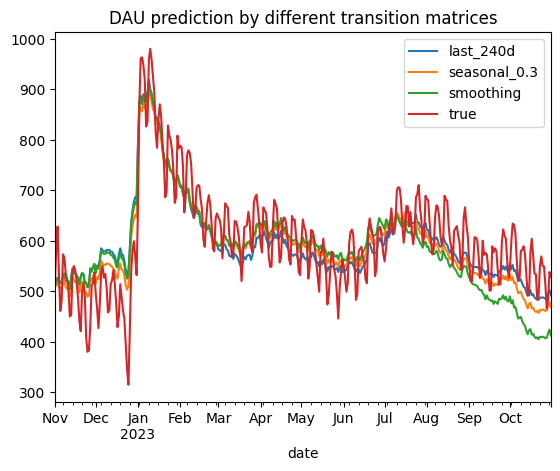

In [29]:
result = pd.DataFrame()
for transition_period in ['last_240d', 'seasonal_0.3', 'smoothing']:
    result[transition_period] = make_prediction('2022-11-01', '2023-10-31', 'true', transition_period)['dau']
result['true'] = dau_true['dau']
result['true'] = result['true'].astype(int)
result.plot(title='DAU prediction by different transition matrices');

In [30]:
mape = pd.DataFrame()
for col in result.columns:
    if col != 'true':
        mape.loc[col, 'mape'] = mean_absolute_percentage_error(result['true'], result[col])
mape

,mape
last_240d,0.080804
seasonal_0.3,0.077545
smoothing,0.097802


According to the MAPE errors, `seasonal_0.3` configuration provides the best results. Interestingly, `smoothing` approach has appeared to be even worse than the `last_240d`. From the diagram above we see that all three models start to underestimate the DAU values in July 2023, especially the `smoothing` model. It seems that the new users who started appearing in July 2023 are more engaged than the users from 2022. Probably, the app was improved sufficiently or the marketing team did a great job. As a result, the `smoothing` model that much relies on the outdated transitions data from July 2022 - October 2022 fails more than the other models.

### Final solution

To sum things up, let's make a final prediction for the 2024 year. We use the `seasonal_0.3` configuration and the predicted values for new users.

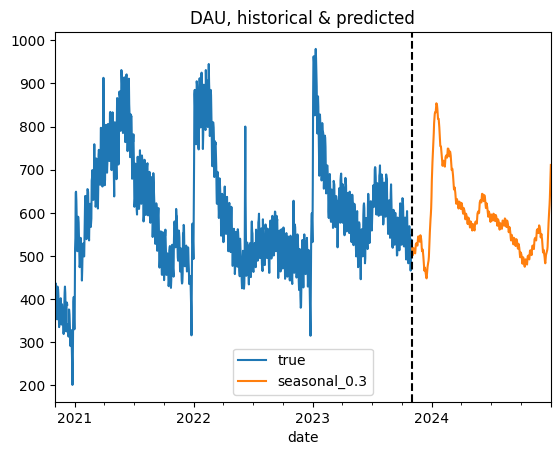

In [31]:
dau_pred = make_prediction(
    PREDICTION_START, PREDICTION_END,
    new_users_mode='predict',
    transition_period='seasonal_0.3'
)
dau_true['dau'].plot(label='true')
dau_pred['dau'].plot(label='seasonal_0.3')
plt.title('DAU, historical & predicted')
plt.axvline(PREDICTION_START, color='k', linestyle='--')
plt.legend();

## Discussion

In the @sec-model-evaluation we studied the model performance from the prediction accuracy perspective. Now let's discuss the model from the practical point of view.
 
Besides poor accuracy, predicting DAU as a time-series (see the @sec-baseline-model) makes this approach very stiff. Essentially, it makes a prediction in such a manner so it would fit *historical* data best. In practice, when making plans for a next year we usually have some certain expectations about the future. For example,

- the marketing team is going to launch some new more effective campaings,
- the activation team is planning to improve the onboarding process,
- the product team will release some new features that would engage and retain users more.

Our model can take into account such expectations. For the examples above we can adjust the new users prediction, the `new`→`current` and the `current`→`current` conversion rates respectively. As a result, we can get a prediction that doesn't match with the historical data but nevertheless would be more realistic. This model's property is not just flexible -- it's interpretable. You can easily discuss all these adjustments with the stakeholders, and they can understand how the prediction works.

Another advantage of the model is that it doesn't require predicting whether a certain user will be active on a certain day. Sometimes binary classifiers are used for this purpose. The downside of this approach is that we need to apply such a classifier to each user including all the dormant users and each day from a prediction horizont. This is a tremedous computational cost. In contrast, the Markov model requires only the initial amount of states (`state0`). Moreover, such classiffiers are often black-box models: they are poorly interpretable and hard to adjust.

The Markov model also has some limitations. As we already have seen, it's sensitive to the new users prediction. It's easy to totally ruin the prediction by a wrong new users amount. Another problem is that the Markov model is memoryless meaning that it doesn't take into account the user's history. For example, it doesn't distinguish whether a `current` user is a newbie, experienced, or `reactivated`/`resurrected` one. The retention rate of these user types should be certainly different. Also, as we discussed earlier, the user behavior might be of different nature depending on the season, marketing sources, countries, etc. So far our model is not able to capture these differences. However, this might be a subject for further research: we could extend the model by fitting more transition matrices for different user segments.

Finally, as we promised in the introduction, we provide a [DAU spreadsheet calculator](https://docs.google.com/spreadsheets/d/1DxbjrkSy_wvU1lzlNWhrEfWO-Kq1tJrQw0izEHu5ULU/edit?usp=sharing). In the `Prediction` sheet you'll need to fill the initial states distribution row (marked with blue) and the new users prediction column (marked with purple). In the `Conversions` sheet you can adjust the transition matrix values. Remember that the sum of each row of the matrix should be equal to 1.

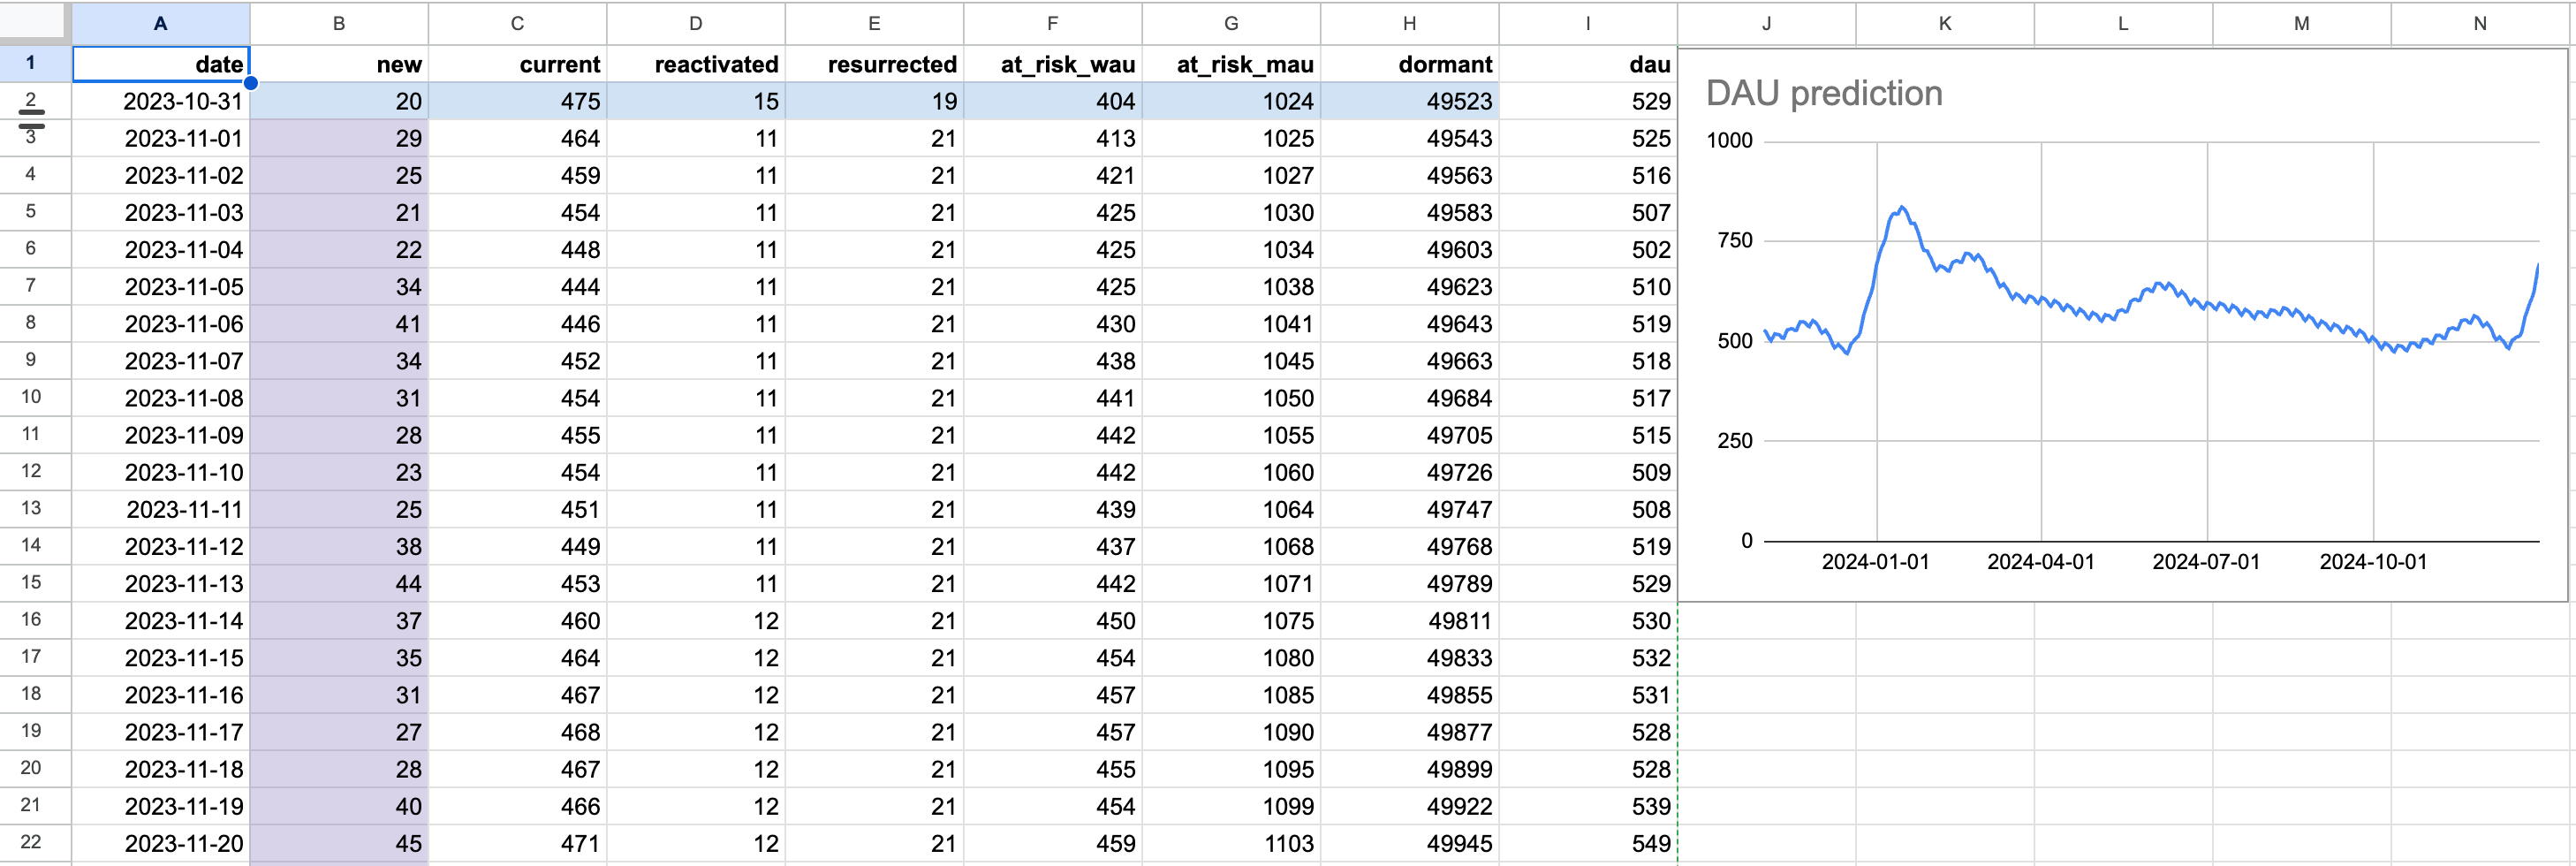

That's all for now. I hope that this article was useful for you. In case of any questions or suggestions, feel free to ask in the comments below or contact me directly on [LinkedIn](https://www.linkedin.com/in/vladimir-kukushkin-95b6487/).